## 4. Data Design

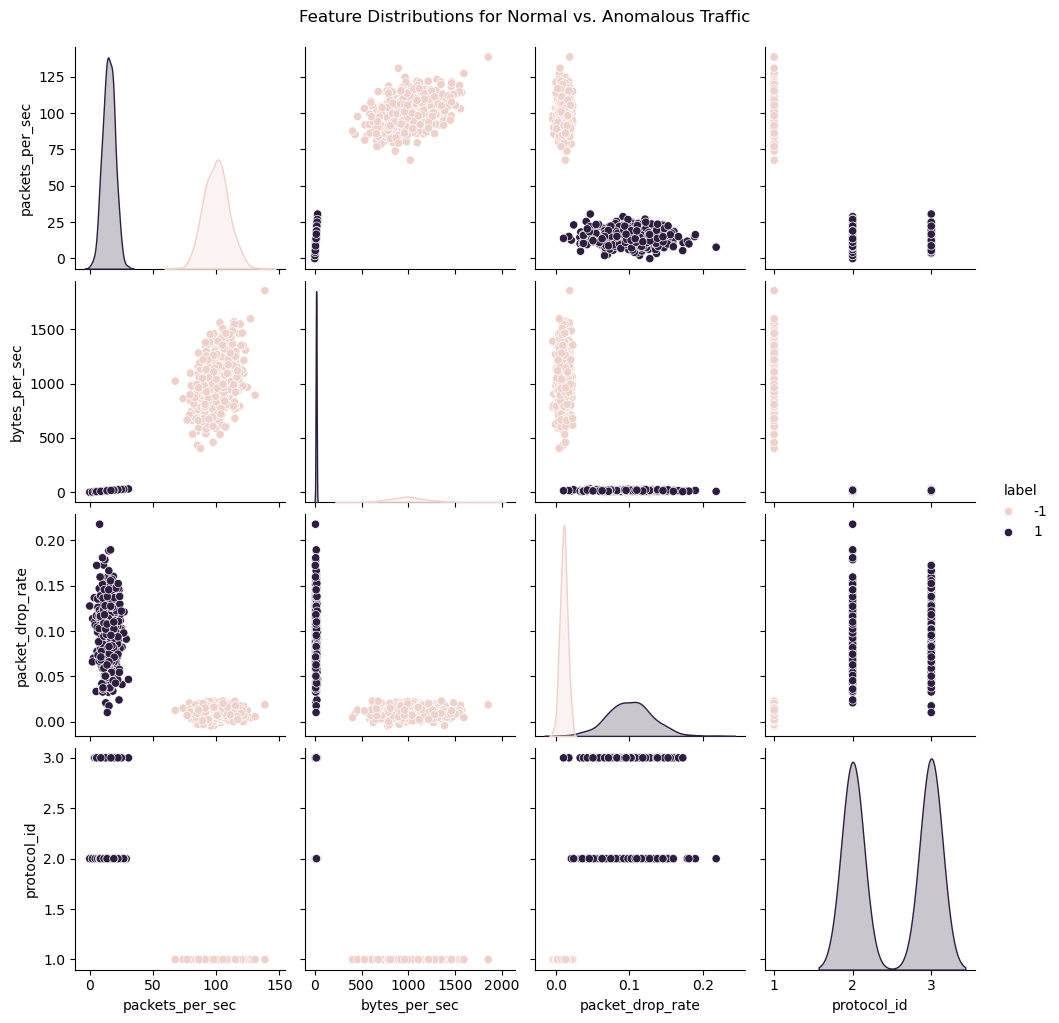

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
np.random.seed(42)

def generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5):
    n_anomalous = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalous
    
    # Normal traffic
    normal_packets = np.random.normal(loc=100, scale=10, size=n_normal)
    normal_bytes = normal_packets * np.random.normal(loc=10, scale=2, size=n_normal)
    normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
    normal_protocol = np.random.choice([1], size=n_normal) # TCP only
    
    # Anomalous traffic
    anomaly_packets = np.random.normal(loc=300, scale=40, size=n_anomalous)
    anomaly_bytes = anomaly_packets = np.random.normal(loc=15, scale=5, size=n_anomalous)
    anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
    anomaly_protocol = np.random.choice([2,3], size=n_anomalous) # sudden protocol change (e.g. UDP, ICMP)
    
    X = np.vstack([
        np.column_stack((normal_packets, normal_bytes, normal_drop_rate, normal_protocol)),
        np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate, anomaly_protocol))
    ])
    
    y = np.array([-1]*n_normal + [1]*n_anomalous)
    
    return pd.DataFrame(X, columns=["packets_per_sec", "bytes_per_sec", "packet_drop_rate", "protocol_id"]), y

X_df, y = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)

sns.pairplot(pd.DataFrame(X_df).assign(label=y), hue="label", diag_kind="kde")
plt.suptitle("Feature Distributions for Normal vs. Anomalous Traffic", y=1.02)
plt.show()

## 5. Preprocessing Pipeline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Training and Optimizer Monitoring

### A. First Quantum Model: ZZFeatureMap + RealAmplitudes + COBYLA

/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_70219/3878668033.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="linear")
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_70219/3878668033.py:5: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=4, reps=2, entanglement="linear")


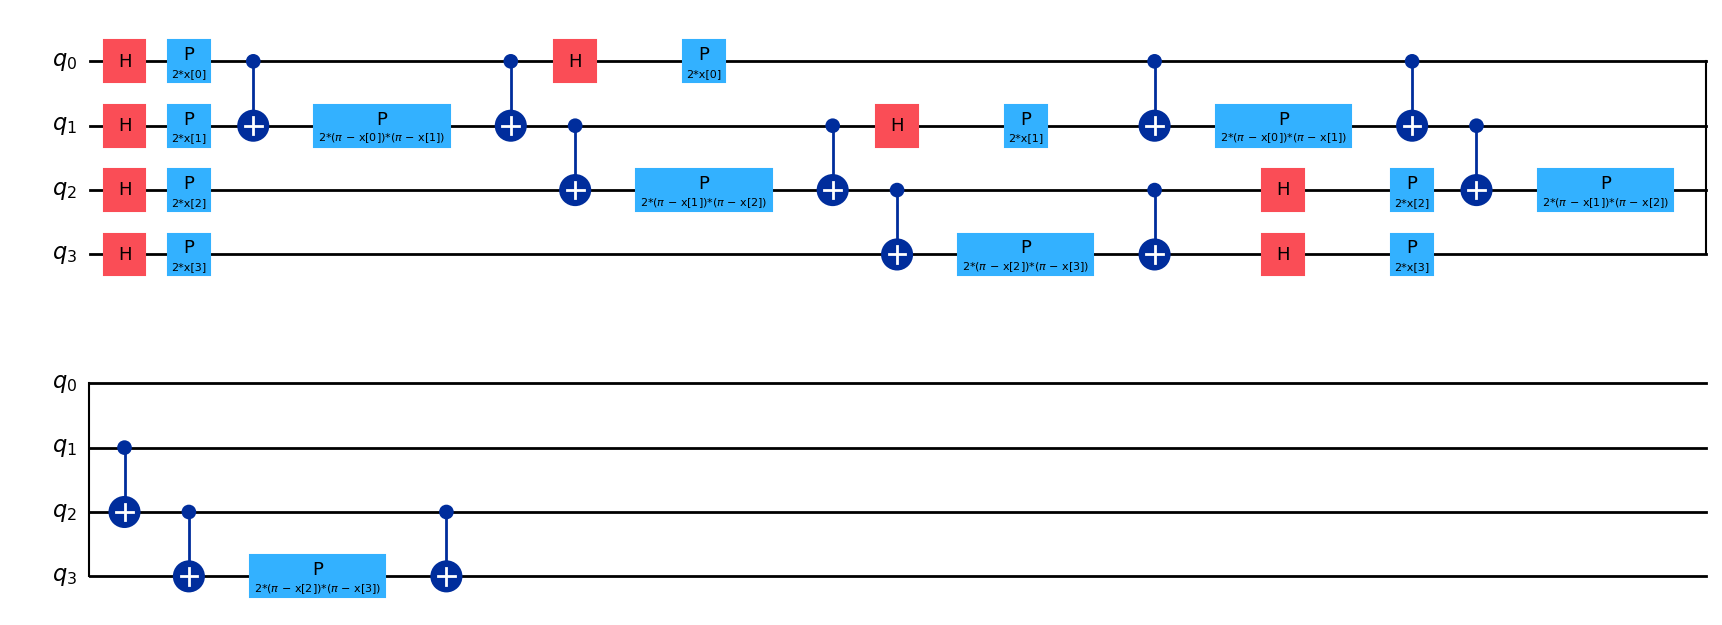

In [3]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# Feature map and ansatz
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="linear")
ansatz = RealAmplitudes(num_qubits=4, reps=2, entanglement="linear")

#Visualize circuits
feature_map.decompose().draw('mpl')

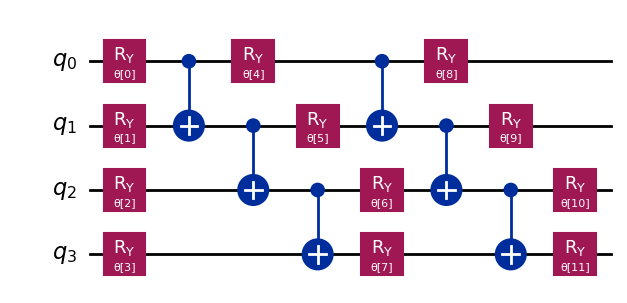

In [4]:
ansatz.decompose().draw('mpl')

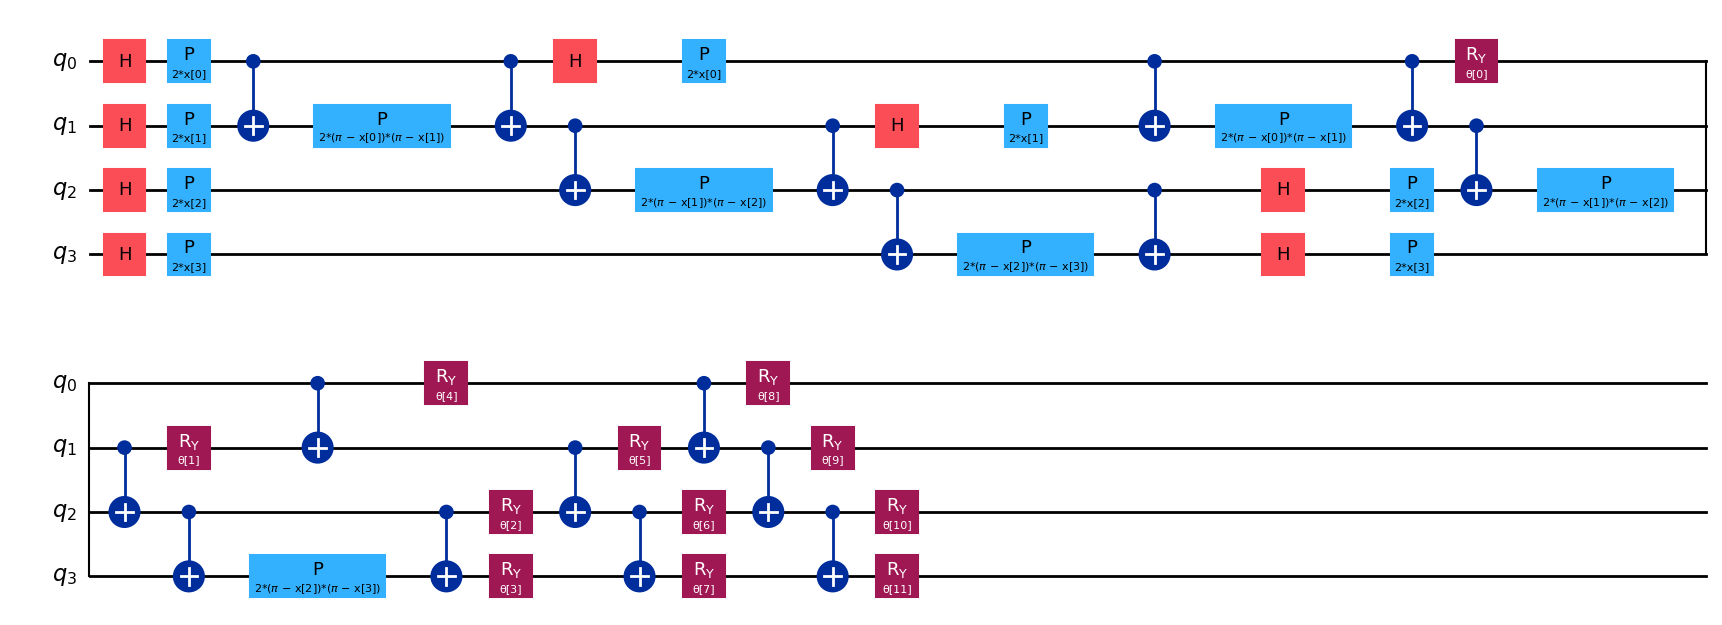

In [12]:
# =========================
# Quantum Circuit
# =========================

qc = QuantumCircuit(4)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qc.decompose().draw('mpl')

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
>>> Training complete.
Elapsed time: 84.90 seconds
Loss values recorded: 0


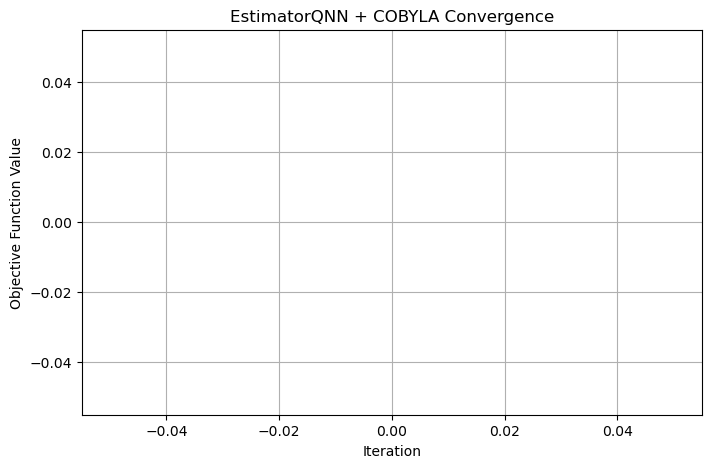

In [5]:
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
from qiskit import QuantumCircuit
import time

# =========================
# Setup
# =========================
np.random.seed(42)
loss_vals = []

# ✅ THIS CALLBACK *WILL* BE CALLED
# def cobyla_callback(x):
#     print("Parameters:", x)

# =========================
# Estimator + QNN (V2)
# =========================
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

# =========================
# Optimizer (WITH CALLBACK)
# =========================
optimizer = COBYLA(
    maxiter=100,
#     callback=cobyla_callback
)

# =========================
# Classifier (NO CALLBACK HERE)
# =========================
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    initial_point=np.random.uniform(-1, 1, qnn.num_weights)
)

# =========================
# Train
# =========================
print(">>> Starting training...")
start = time.time()

classifier.fit(X_train_scaled, y_train)

end = time.time()
print(">>> Training complete.")
print(f"Elapsed time: {end-start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8,5))
plt.plot(loss_vals, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + COBYLA Convergence")
plt.grid(True)
plt.show()


▶ Evaluation Metrics (VQC-1)
Accuracy : 0.763
Precision: 0.763
Recall   : 0.763
F1 Score : 0.763


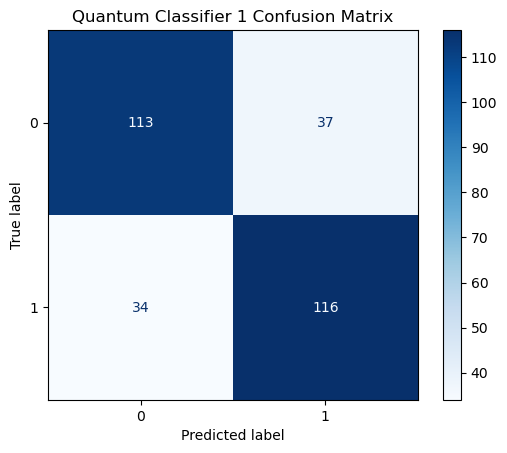


▶ Debug Info
Unique true labels : [-1  1]
Unique predicted labels: [-1.  1.]


In [6]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# =========================
# PREDICTION
# =========================
y_pred = classifier.predict(X_test_scaled)
y_pred = np.asarray(y_pred)

# =========================
# METRICS (ROBUST)
# =========================
acc_1 = accuracy_score(y_test, y_pred)
prec_1 = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec_1 = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n▶ Evaluation Metrics (VQC-1)")
print(f"Accuracy : {acc_1:.3f}")
print(f"Precision: {prec_1:.3f}")
print(f"Recall   : {rec_1:.3f}")
print(f"F1 Score : {f1_1:.3f}")

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Quantum Classifier 1 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred))

## B. Second Quantum Model: PauliFeatureMap + TwoLocal + SPSA

/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_70219/1527967508.py:6: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the pauli_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map_2 = PauliFeatureMap(feature_dimension=4, reps=2, paulis=['X', 'Y', 'Z'])
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_70219/1527967508.py:7: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz_2 = TwoLocal(num_qubits=4, reps=2, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear')


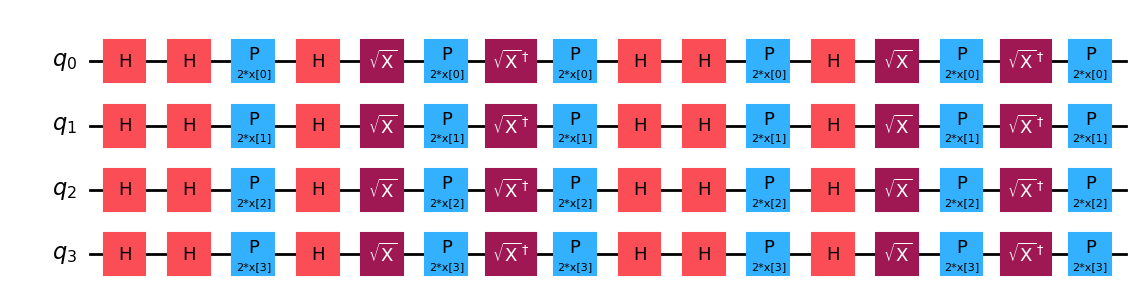

In [8]:
from qiskit.circuit.library import PauliFeatureMap, TwoLocal
from qiskit_algorithms.optimizers import SPSA

# Define the new feature map and ansatz
feature_map_2 = PauliFeatureMap(feature_dimension=4, reps=2, paulis=['X', 'Y', 'Z'])
ansatz_2 = TwoLocal(num_qubits=4, reps=2, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear')

# Visualize circuits
feature_map_2.decompose().draw('mpl')

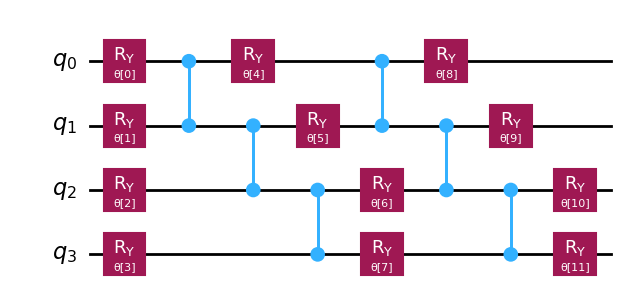

In [10]:
ansatz_2.decompose().draw('mpl')

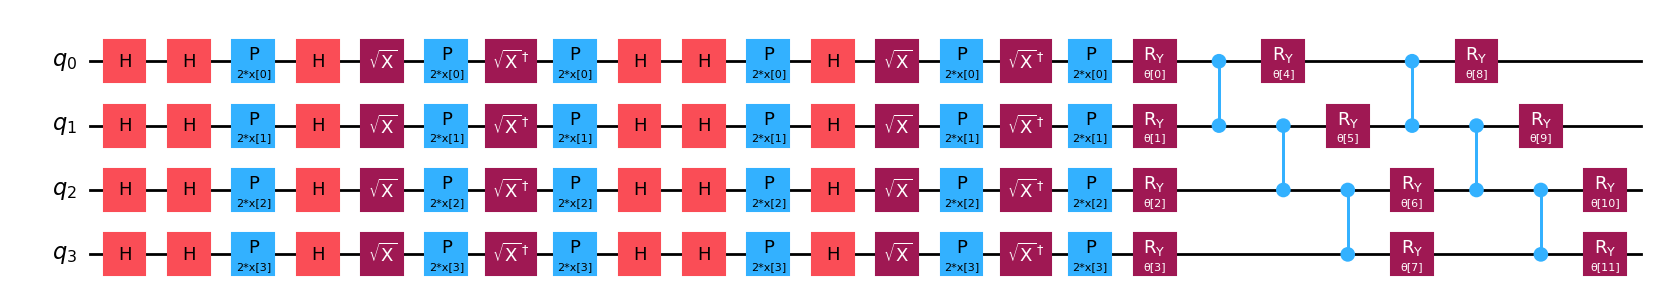

In [14]:
# =========================
# Quantum Circuit
# =========================

qc_2 = QuantumCircuit(4)
qc_2.compose(feature_map_2, inplace=True)
qc_2.compose(ansatz_2, inplace=True)

qc_2.decompose().draw('mpl')

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
>>> Training complete.
Elapsed time: 295.02 seconds
Loss values recorded: 0


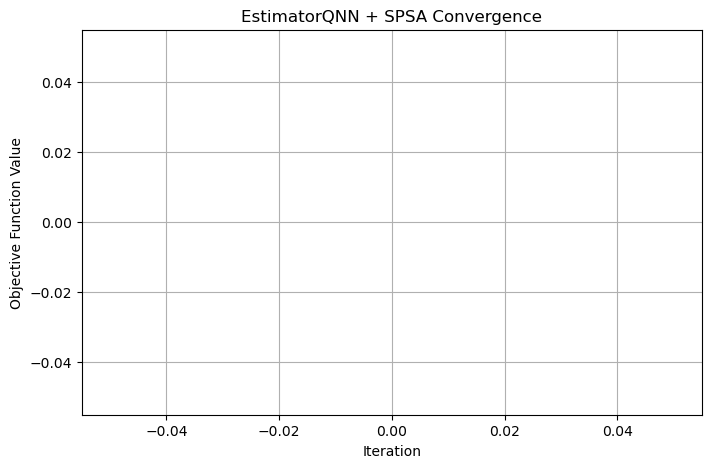

In [20]:
np.random.seed(42)
loss_vals_2 = []

def spsa_callback(nfev, params, value, stepsize, accepted):
    print(f"[{nfev:03}] Loss = {value:.6f}", flush=True)
    loss_vals_2.append(value)
    
# =========================
# Estimator + QNN (V2)
# =========================
estimator_2 = StatevectorEstimator()

qnn_2 = EstimatorQNN(
    circuit=qc_2,
    input_params=feature_map_2.parameters,
    weight_params=ansatz_2.parameters,
    estimator=estimator_2
)

# =========================
# Optimizer (WITH CALLBACK)
# =========================
optimizer_2 = SPSA(
    maxiter=100,
    callback=spsa_callback
)

classifier_2 = NeuralNetworkClassifier(
    neural_network=qnn_2,
    optimizer=optimizer_2,
    initial_point=np.random.uniform(-1, 1, qnn_2.num_weights)
)

# =========================
# Train
# =========================
print(">>> Starting training...")
start = time.time()

classifier_2.fit(X_train_scaled, y_train)

end = time.time()
print(">>> Training complete.")
print(f"Elapsed time: {end - start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals_2)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8, 5))
plt.plot(loss_vals_2, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + SPSA Convergence")
plt.grid(True)
plt.show()


▶ Evaluation Metrics (VQC-2)
Accuracy : 0.877
Precision: 0.879
Recall   : 0.877
F1 Score : 0.877


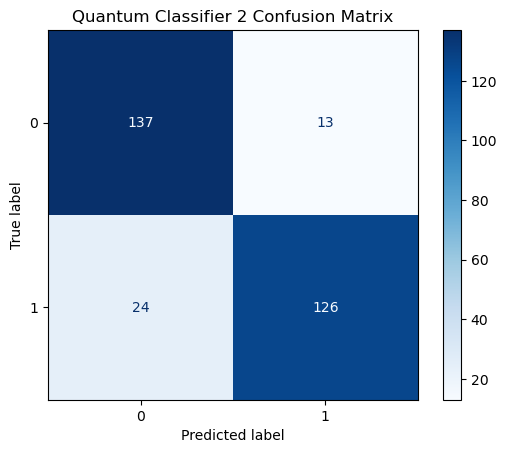


▶ Debug Info
Unique true labels : [-1  1]
Unique predicted labels: [-1.  1.]


In [19]:
y_pred_2 = classifier_2.predict(X_test_scaled)
y_pred_2 = np.asarray(y_pred_2)

acc_2 = accuracy_score(y_test, y_pred_2)

prec_2 = precision_score(y_test, y_pred_2, average="macro", zero_division=0)
rec_2 = recall_score(y_test, y_pred_2, average="macro", zero_division=0)
f1_2 = f1_score(y_test, y_pred_2, average="macro", zero_division=0)

print("\n▶ Evaluation Metrics (VQC-2)")
print(f"Accuracy : {acc_2:.3f}")
print(f"Precision: {prec_2:.3f}")
print(f"Recall   : {rec_2:.3f}")
print(f"F1 Score : {f1_2:.3f}")

cm_2 = confusion_matrix(y_test, y_pred_2)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp_2.plot(cmap="Blues", values_format="d")

plt.title("Quantum Classifier 2 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred_2))

## C. Third Quantum Model: ZFeatureMap + RealAmplitudes + ADAM

/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_70219/2887202053.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map_3 = ZFeatureMap(feature_dimension=4, reps=2)
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_70219/2887202053.py:5: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz_3 = RealAmplitudes(num_qubits=4, reps=3, entanglement='linear')


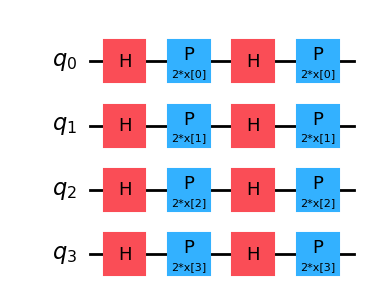

In [21]:
from qiskit.circuit.library import ZFeatureMap

# Define the new feature map and ansatz
feature_map_3 = ZFeatureMap(feature_dimension=4, reps=2)
ansatz_3 = RealAmplitudes(num_qubits=4, reps=3, entanglement='linear')

# Visualize circuits
feature_map_3.decompose().draw('mpl')

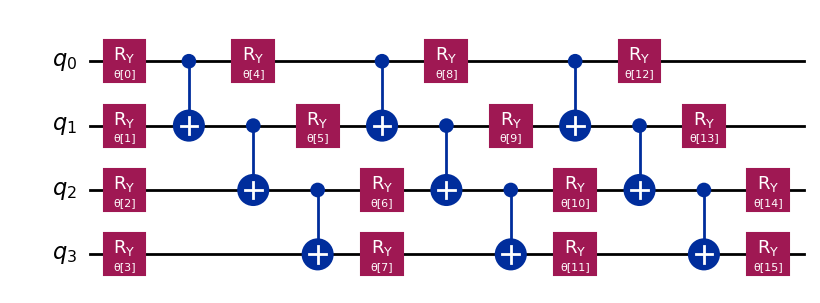

In [22]:
ansatz_3.decompose().draw('mpl')

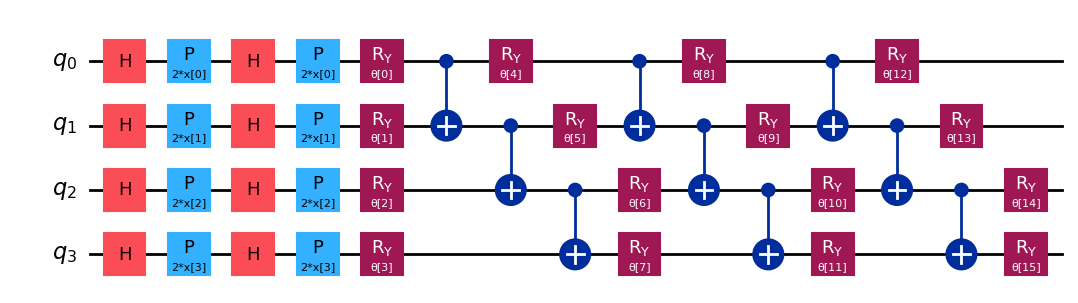

In [24]:
# =========================
# Quantum Circuit
# =========================

qc_3 = QuantumCircuit(4)
qc_3.compose(feature_map_3, inplace=True)
qc_3.compose(ansatz_3, inplace=True)

qc_3.decompose().draw('mpl')

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
>>> Training complete.
Elapsed time: 797.74 seconds
Loss values recorded: 0


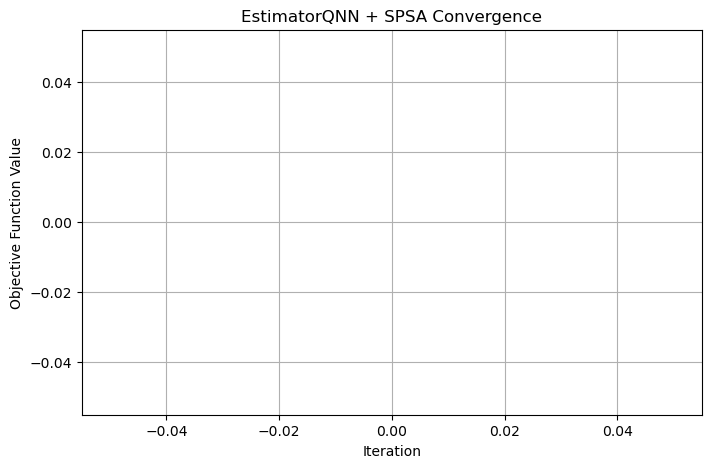

In [26]:
from qiskit_algorithms.optimizers import ADAM

np.random.seed(42)
loss_vals_3 = []

# def adam_callback(nfev, params, value, stepsize, accepted):
#     print(f"[{nfev:03}] Loss = {value:.6f}", flush=True)
#     loss_vals_2.append(value)
    
# =========================
# Estimator + QNN (V2)
# =========================
estimator_3 = StatevectorEstimator()

qnn_3 = EstimatorQNN(
    circuit=qc_3,
    input_params=feature_map_3.parameters,
    weight_params=ansatz_3.parameters,
    estimator=estimator_3
)

# =========================
# Optimizer (WITH CALLBACK)
# =========================
optimizer_3 = ADAM(maxiter=40, lr=0.1)

classifier_3 = NeuralNetworkClassifier(
    neural_network=qnn_3,
    optimizer=optimizer_3,
    initial_point=np.random.uniform(-1, 1, qnn_3.num_weights)
)

# =========================
# Train
# =========================
print(">>> Starting training...")
start = time.time()

classifier_3.fit(X_train_scaled, y_train)

end = time.time()
print(">>> Training complete.")
print(f"Elapsed time: {end - start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals_3)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8, 5))
plt.plot(loss_vals_3, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + ADAM Convergence")
plt.grid(True)
plt.show()


▶ Evaluation Metrics (VQC-3)
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1 Score : 1.000


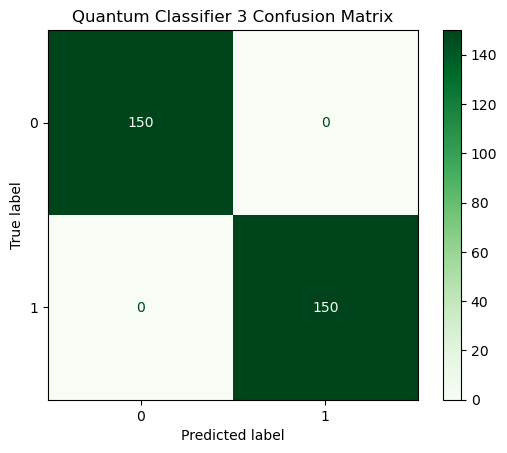


▶ Debug Info
Unique true labels : [-1  1]
Unique predicted labels: [-1.  1.]


In [27]:
y_pred_3 = classifier_3.predict(X_test_scaled)
y_pred_3 = np.asarray(y_pred_3)

acc_3 = accuracy_score(y_test, y_pred_3)

prec_3 = precision_score(y_test, y_pred_3, average="macro", zero_division=0)
rec_3 = recall_score(y_test, y_pred_3, average="macro", zero_division=0)
f1_3 = f1_score(y_test, y_pred_3, average="macro", zero_division=0)

print("\n▶ Evaluation Metrics (VQC-3)")
print(f"Accuracy : {acc_3:.3f}")
print(f"Precision: {prec_3:.3f}")
print(f"Recall   : {rec_3:.3f}")
print(f"F1 Score : {f1_3:.3f}")

cm_3 = confusion_matrix(y_test, y_pred_3)

disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3)
disp_3.plot(cmap="Greens", values_format="d")

plt.title("Quantum Classifier 3 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred_3))

got 100% accuracy using vqc-3, need to inspect target leakage lol